# Clasificación Marea Roja

### Lectura, integración y limpieza de los datos

**Importacion de las librerias necesarias**

In [2]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
#!pip3 install ipympl

**Lectura de los datos de Analisis 2021**

In [3]:
#!pip install xlrd
mareaRoja_2021 = pd.read_excel("../data/external/TPM 2021.xls", sheet_name="Hoja1", skipfooter=2)
mareaRoja_2021.head()

,Fecha análisis,N° muestra,Producto,Zona,Resultado
0,2021-01-06,1,M,ARTF 005,ND
1,2021-01-06,2,M,ARTF 002,ND
2,2021-01-06,3,Ch,ARTF 006,ND
3,2021-01-06,4,M,ARTF 001,ND
4,2021-01-06,5,M,ARTF 003,ND


**Lectura de los datos de Analisis 2022**

In [4]:
mareaRoja_2022 = pd.read_excel("../data/external/TPM 2022.xls", sheet_name="Hoja1", usecols=(0,1,2,3,4))
mareaRoja_2022.head()

,Fecha análisis,N° muestra,Producto,Zona,Resultado
0,2022-01-06,1,M,ARTF 001,ND
1,2022-01-06,2,M,ARTF 002,ND
2,2022-01-06,3,Ch,Pso. Guaraní,ND
3,2022-01-06,4,Ch,ARTF 002,ND
4,2022-01-06,5,M,ARTF 002,ND


**Unión de ambos dataframes y visualización de información de sus columnas**

In [5]:
datosMareaRoja = pd.concat([mareaRoja_2021, mareaRoja_2022], axis=0)
datosMareaRoja.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 265 entries, 0 to 104
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Fecha análisis  265 non-null    datetime64[ns]
 1   N° muestra      265 non-null    int64         
 2   Producto        265 non-null    object        
 3   Zona            265 non-null    object        
 4   Resultado       265 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 12.4+ KB


**Calculo de medidas descriptivas**

In [6]:
datosMareaRoja.describe()

,N° muestra
count,265.000000
mean,83.750943
std,51.551077
min,1.000000
25%,40.000000
50%,80.000000
75%,127.000000
max,187.000000


**Visualizacion de valores de la columna Resultado**

In [7]:
datosMareaRoja.Resultado.value_counts()

ND         130
522.69       3
459.46       2
398.47       2
399          2
          ... 
402.53       1
394.74       1
554.61       1
442.89       1
4814.14      1
Name: Resultado, Length: 119, dtype: int64

In [8]:
datosMareaRoja[datosMareaRoja.Resultado == "No Apto"]

,Fecha análisis,N° muestra,Producto,Zona,Resultado
51,2022-02-16,60,M,B. Lapataia,No Apto
52,2022-02-16,61,M,Monte Susana,No Apto


**Reemplazo de los valores no detectados por ceros**

In [9]:
datosMareaRoja["Resultado"] = datosMareaRoja["Resultado"].replace("ND",0)
datosMareaRoja["Resultado"] = datosMareaRoja["Resultado"].replace("No Apto",0)
datosMareaRoja["Resultado"] = datosMareaRoja["Resultado"].astype("float64")
datosMareaRoja.Resultado.value_counts()

0.00       132
522.69       3
459.46       2
398.47       2
399.00       2
          ... 
402.53       1
394.74       1
554.61       1
442.89       1
4814.14      1
Name: Resultado, Length: 118, dtype: int64

**Selección columnas relevantes**

In [10]:
datos_MR_Relevantes = datosMareaRoja.iloc[:,[0,4]]
datos_MR_Relevantes.head()

,Fecha análisis,Resultado
0,2021-01-06,0.0
1,2021-01-06,0.0
2,2021-01-06,0.0
3,2021-01-06,0.0
4,2021-01-06,0.0


**Agrupamiento de los datos por fecha**

In [11]:
Relevantes_MR_Aggr = datos_MR_Relevantes.groupby(datos_MR_Relevantes["Fecha análisis"]).mean()
Relevantes_MR_Aggr = Relevantes_MR_Aggr.reset_index()
Relevantes_MR_Aggr = Relevantes_MR_Aggr.rename(columns={'Fecha análisis':'Fecha'})
Relevantes_MR_Aggr.head()

,Fecha,Resultado
0,2021-01-06,0.000000
1,2021-01-11,0.000000
2,2021-01-20,191.160000
3,2021-01-28,616.461667
4,2021-02-03,689.932500


**Creacion columna target y visualización de su distribución**

In [12]:
Relevantes_MR_Aggr["ResultadoBool"] = [ 1 if resultado != 0 else 0 for resultado in Relevantes_MR_Aggr["Resultado"]]
Relevantes_MR_Aggr["ResultadoBool"].value_counts()

1    49
0    19
Name: ResultadoBool, dtype: int64

**Cambio de formato de fecha para compatibilizar datos de otras fuentes**

In [13]:
DOY= []
for date in Relevantes_MR_Aggr["Fecha"]:
    DOY.append(date.timetuple().tm_yday)
Relevantes_MR_Aggr["DOY"] = DOY
Relevantes_MR_Aggr["YEAR"] = Relevantes_MR_Aggr["Fecha"].dt.year
Relevantes_MR_Aggr.drop(["Fecha"], axis=1, inplace=True)
Relevantes_MR_Aggr.head()

,Resultado,ResultadoBool,DOY,YEAR
0,0.000000,0,6,2021
1,0.000000,0,11,2021
2,191.160000,1,20,2021
3,616.461667,1,28,2021
4,689.932500,1,34,2021


**Lectura datos meteorologicos y visualización de sus primeras filas**

In [14]:
datos_sat = pd.read_csv("../data/external/Datos Meteorologicos Power Larc NASA.csv", skiprows=26)
datos_sat.head()

,YEAR,DOY,ALLSKY_SFC_PAR_TOT,CLRSKY_SFC_PAR_TOT,T2M,T2MDEW,T2MWET,TS,T2M_RANGE,T2M_MAX,T2M_MIN,QV2M,RH2M,PRECTOTCORR,PS,WS2M,WS2M_MAX,WS2M_MIN,WS2M_RANGE,WD2M
0,2021,1,59.94,171.83,11.77,8.47,10.12,11.42,6.28,14.90,8.62,7.20,80.31,1.26,96.10,5.19,7.13,2.09,5.05,309.56
1,2021,2,116.66,171.41,9.54,3.92,6.73,9.94,6.98,12.67,5.68,5.25,68.88,0.19,95.69,8.02,10.12,3.91,6.20,290.12
2,2021,3,114.19,171.79,6.51,2.30,4.40,7.62,5.15,9.02,3.87,4.64,75.19,1.76,96.63,5.41,6.98,3.82,3.16,273.00
3,2021,4,92.84,170.17,6.67,2.87,4.77,7.32,6.82,10.16,3.33,4.82,77.25,1.92,97.60,5.70,7.30,3.93,3.37,285.50
4,2021,5,108.02,170.68,9.35,4.98,7.16,9.62,7.76,12.90,5.15,5.55,75.12,0.18,97.72,4.58,6.22,1.74,4.48,298.25


**Visualización informacion de las columnas**

In [15]:
datos_sat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   YEAR                730 non-null    int64  
 1   DOY                 730 non-null    int64  
 2   ALLSKY_SFC_PAR_TOT  730 non-null    float64
 3   CLRSKY_SFC_PAR_TOT  730 non-null    float64
 4   T2M                 730 non-null    float64
 5   T2MDEW              730 non-null    float64
 6   T2MWET              730 non-null    float64
 7   TS                  730 non-null    float64
 8   T2M_RANGE           730 non-null    float64
 9   T2M_MAX             730 non-null    float64
 10  T2M_MIN             730 non-null    float64
 11  QV2M                730 non-null    float64
 12  RH2M                730 non-null    float64
 13  PRECTOTCORR         730 non-null    float64
 14  PS                  730 non-null    float64
 15  WS2M                730 non-null    float64
 16  WS2M_MAX

**Calculo de medidas descriptivas columnas numericas**

In [16]:
datos_sat.describe()

,YEAR,DOY,ALLSKY_SFC_PAR_TOT,CLRSKY_SFC_PAR_TOT,T2M,T2MDEW,T2MWET,TS,T2M_RANGE,T2M_MAX,T2M_MIN,QV2M,RH2M,PRECTOTCORR,PS,WS2M,WS2M_MAX,WS2M_MIN,WS2M_RANGE,WD2M
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,2021.500000,183.000000,53.750534,86.418425,3.998945,1.378301,2.688671,4.348932,5.457973,6.713603,1.255479,4.446493,84.146836,1.998945,96.741945,5.013548,7.026795,2.817699,4.209014,263.340548
std,0.500343,105.438271,39.876552,57.148182,3.486438,2.831808,3.091377,3.518728,2.366509,4.294672,2.809476,0.926139,8.003152,9.768360,1.051487,1.970849,2.383783,1.686210,1.783566,53.761216
min,2021.000000,1.000000,2.220000,13.470000,-4.940000,-6.070000,-5.450000,-6.290000,0.760000,-2.790000,-6.820000,2.440000,63.620000,0.000000,93.160000,1.210000,1.670000,0.060000,0.420000,11.880000
25%,2021.000000,92.000000,16.285000,29.445000,1.672500,-0.415000,0.625000,1.800000,3.622500,3.370000,-0.430000,3.850000,77.705000,0.322500,96.050000,3.472500,5.392500,1.610000,2.920000,241.327500
50%,2021.500000,183.000000,45.585000,79.650000,4.005000,1.360000,2.650000,4.385000,5.250000,6.830000,1.290000,4.390000,83.845000,0.905000,96.720000,4.905000,6.980000,2.420000,4.010000,274.625000
75%,2022.000000,274.000000,84.742500,143.210000,6.387500,3.170000,4.635000,7.015000,7.005000,9.640000,3.002500,5.000000,91.120000,2.160000,97.497500,6.400000,8.635000,3.745000,5.230000,298.425000
max,2022.000000,365.000000,166.400000,175.960000,15.520000,10.660000,13.090000,14.830000,14.240000,20.370000,10.940000,8.240000,99.560000,249.650000,99.780000,10.630000,15.430000,9.540000,12.260000,352.810000


**Unión datos meteorologicos y datos de analisis de marea roja segun su fecha**

In [17]:
df_unido = pd.merge(datos_sat,Relevantes_MR_Aggr, on=["YEAR","DOY"], how='outer')

df_unido.head(10)

,YEAR,DOY,ALLSKY_SFC_PAR_TOT,CLRSKY_SFC_PAR_TOT,T2M,T2MDEW,T2MWET,TS,T2M_RANGE,T2M_MAX,...,RH2M,PRECTOTCORR,PS,WS2M,WS2M_MAX,WS2M_MIN,WS2M_RANGE,WD2M,Resultado,ResultadoBool
0,2021,1,59.94,171.83,11.77,8.47,10.12,11.42,6.28,14.90,...,80.31,1.26,96.10,5.19,7.13,2.09,5.05,309.56,NaN,NaN
1,2021,2,116.66,171.41,9.54,3.92,6.73,9.94,6.98,12.67,...,68.88,0.19,95.69,8.02,10.12,3.91,6.20,290.12,NaN,NaN
2,2021,3,114.19,171.79,6.51,2.30,4.40,7.62,5.15,9.02,...,75.19,1.76,96.63,5.41,6.98,3.82,3.16,273.00,NaN,NaN
3,2021,4,92.84,170.17,6.67,2.87,4.77,7.32,6.82,10.16,...,77.25,1.92,97.60,5.70,7.30,3.93,3.37,285.50,NaN,NaN
4,2021,5,108.02,170.68,9.35,4.98,7.16,9.62,7.76,12.90,...,75.12,0.18,97.72,4.58,6.22,1.74,4.48,298.25,NaN,NaN
5,2021,6,78.01,169.05,9.36,6.72,8.04,9.23,6.48,12.54,...,84.19,1.02,96.90,3.27,5.56,1.10,4.46,318.75,0.0,0.0
6,2021,7,108.91,170.47,8.56,4.15,6.36,9.17,8.06,12.43,...,74.75,0.85,96.50,4.38,6.33,1.88,4.45,292.75,NaN,NaN
7,2021,8,109.77,168.52,8.66,4.01,6.34,9.31,6.36,11.79,...,74.00,1.23,96.23,4.97,6.77,2.95,3.81,309.62,NaN,NaN
8,2021,9,118.98,166.16,8.12,3.21,5.66,8.76,5.76,10.73,...,73.06,1.19,95.35,2.91,5.98,1.49,4.49,209.31,NaN,NaN
9,2021,10,55.50,166.94,4.69,3.17,3.93,5.86,4.04,6.35,...,89.75,5.24,95.32,5.16,7.10,1.69,5.41,172.19,NaN,NaN


**Cambio de tipo de dato columna ResultadoBool a categoria**

In [18]:
df_unido.ResultadoBool = df_unido.ResultadoBool.astype("category")
df_unido.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 0 to 729
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   YEAR                730 non-null    int64   
 1   DOY                 730 non-null    int64   
 2   ALLSKY_SFC_PAR_TOT  730 non-null    float64 
 3   CLRSKY_SFC_PAR_TOT  730 non-null    float64 
 4   T2M                 730 non-null    float64 
 5   T2MDEW              730 non-null    float64 
 6   T2MWET              730 non-null    float64 
 7   TS                  730 non-null    float64 
 8   T2M_RANGE           730 non-null    float64 
 9   T2M_MAX             730 non-null    float64 
 10  T2M_MIN             730 non-null    float64 
 11  QV2M                730 non-null    float64 
 12  RH2M                730 non-null    float64 
 13  PRECTOTCORR         730 non-null    float64 
 14  PS                  730 non-null    float64 
 15  WS2M                730 non-null    floa

**Manejo de valores nulos**

*Se separa el dataset por año y se rellenan los nulos en relacion a sus valores cercanos.*

In [19]:
df_unido_2021 = df_unido.copy()[df_unido["YEAR"] == 2021]
df_unido_2021["ResultadoBool"].fillna( method ='bfill', inplace = True)
df_unido_2021["ResultadoBool"].fillna( value= 0, inplace = True)
pd.set_option("display.max_rows", 10)
df_unido_2021.head()

,YEAR,DOY,ALLSKY_SFC_PAR_TOT,CLRSKY_SFC_PAR_TOT,T2M,T2MDEW,T2MWET,TS,T2M_RANGE,T2M_MAX,...,RH2M,PRECTOTCORR,PS,WS2M,WS2M_MAX,WS2M_MIN,WS2M_RANGE,WD2M,Resultado,ResultadoBool
0,2021,1,59.94,171.83,11.77,8.47,10.12,11.42,6.28,14.90,...,80.31,1.26,96.10,5.19,7.13,2.09,5.05,309.56,NaN,0.0
1,2021,2,116.66,171.41,9.54,3.92,6.73,9.94,6.98,12.67,...,68.88,0.19,95.69,8.02,10.12,3.91,6.20,290.12,NaN,0.0
2,2021,3,114.19,171.79,6.51,2.30,4.40,7.62,5.15,9.02,...,75.19,1.76,96.63,5.41,6.98,3.82,3.16,273.00,NaN,0.0
3,2021,4,92.84,170.17,6.67,2.87,4.77,7.32,6.82,10.16,...,77.25,1.92,97.60,5.70,7.30,3.93,3.37,285.50,NaN,0.0
4,2021,5,108.02,170.68,9.35,4.98,7.16,9.62,7.76,12.90,...,75.12,0.18,97.72,4.58,6.22,1.74,4.48,298.25,NaN,0.0


In [20]:
df_unido_2022 = df_unido.copy()[df_unido["YEAR"] == 2022]
df_unido_2022["ResultadoBool"].fillna( method ='bfill', inplace = True)
df_unido_2022["ResultadoBool"].fillna( value= 0, inplace = True)
pd.set_option("display.max_rows", 10)
df_unido_2022.head()

,YEAR,DOY,ALLSKY_SFC_PAR_TOT,CLRSKY_SFC_PAR_TOT,T2M,T2MDEW,T2MWET,TS,T2M_RANGE,T2M_MAX,...,RH2M,PRECTOTCORR,PS,WS2M,WS2M_MAX,WS2M_MIN,WS2M_RANGE,WD2M,Resultado,ResultadoBool
365,2022,1,53.06,173.68,7.11,3.52,5.32,7.44,7.97,11.00,...,78.44,3.93,94.03,6.05,9.32,1.97,7.35,239.00,NaN,0.0
366,2022,2,117.71,173.32,3.99,-0.66,1.66,5.55,4.88,6.58,...,72.56,0.95,94.48,9.87,12.12,7.20,4.92,257.69,NaN,0.0
367,2022,3,130.62,173.03,4.49,-0.72,1.89,6.33,6.36,8.07,...,70.50,0.80,95.35,6.21,7.30,4.55,2.76,244.12,NaN,0.0
368,2022,4,113.98,170.30,4.33,0.05,2.19,5.87,4.59,6.80,...,74.81,1.39,96.67,5.62,7.66,1.80,5.85,249.38,NaN,0.0
369,2022,5,148.79,172.23,7.52,3.12,5.32,8.37,8.52,11.32,...,75.00,0.91,96.57,5.95,8.85,1.66,7.19,275.81,NaN,0.0


*Se vuelve a unir el dataset y se visualizan los valores de la columna target luego del tratamiento de nulos.*

In [21]:
df_unido = pd.concat([df_unido_2021,df_unido_2022],axis=0)
df_unido.ResultadoBool.value_counts()

0.0    544
1.0    186
Name: ResultadoBool, dtype: int64

### Exploración de los datos

**Visualización de las distribuciones de las variables numericas en relacion al resultado del analisis**

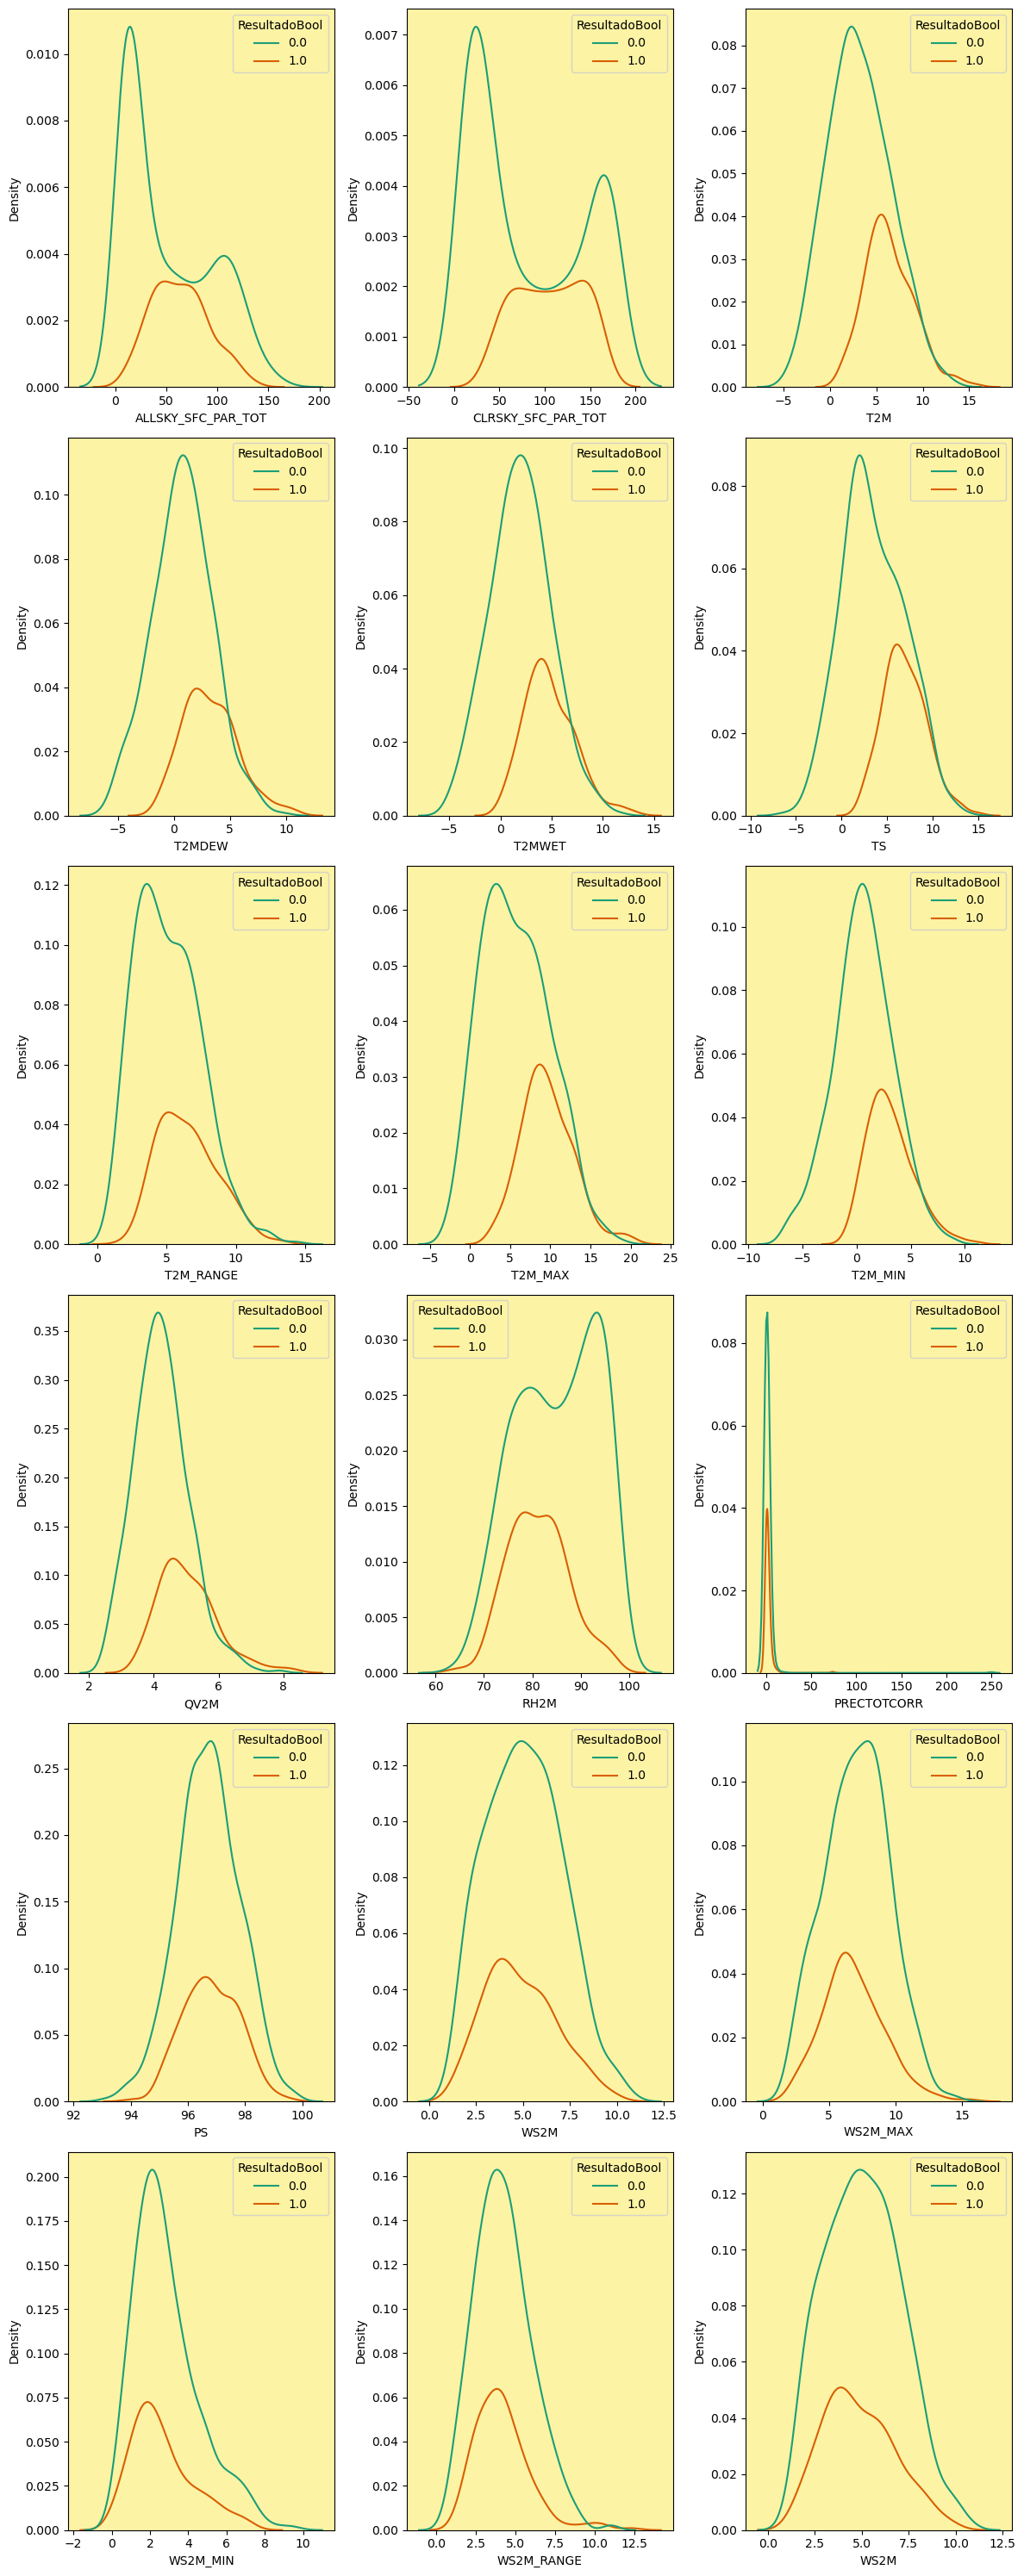

In [591]:
sns.set_style(rc = {'axes.facecolor': '#FCF3A5'})

sns.set_palette("Dark2")
columnas= ["ALLSKY_SFC_PAR_TOT","CLRSKY_SFC_PAR_TOT","T2M","T2MDEW","T2MWET","TS","T2M_RANGE","T2M_MAX","T2M_MIN",
           "QV2M","RH2M","PRECTOTCORR","PS","WS2M","WS2M_MAX","WS2M_MIN","WS2M_RANGE","WS2M"]
index = 1
fig, ((ax1, ax2,ax3), (ax4, ax5,ax6),(ax7, ax8,ax9),
    (ax10, ax11,ax12),(ax13, ax14,ax15),(ax16, ax17,ax18)) = plt.subplots(6, 3, figsize=(12,30))
figuras = {"ax1":ax1,"ax2":ax2,"ax3":ax3,"ax4":ax4,"ax5":ax5,"ax6":ax6,"ax7":ax7,"ax8":ax8,"ax9":ax9,"ax10":ax10,
           "ax11":ax11,"ax12":ax12,"ax13":ax13,"ax14":ax14,"ax15":ax15,"ax16":ax16,"ax17":ax17,"ax18":ax18 }

for columna in columnas:
    sns.kdeplot(ax=figuras["ax"+str(index)], data= df_unido, x = columna, hue="ResultadoBool")
    index +=1

plt.tight_layout()
plt.show()


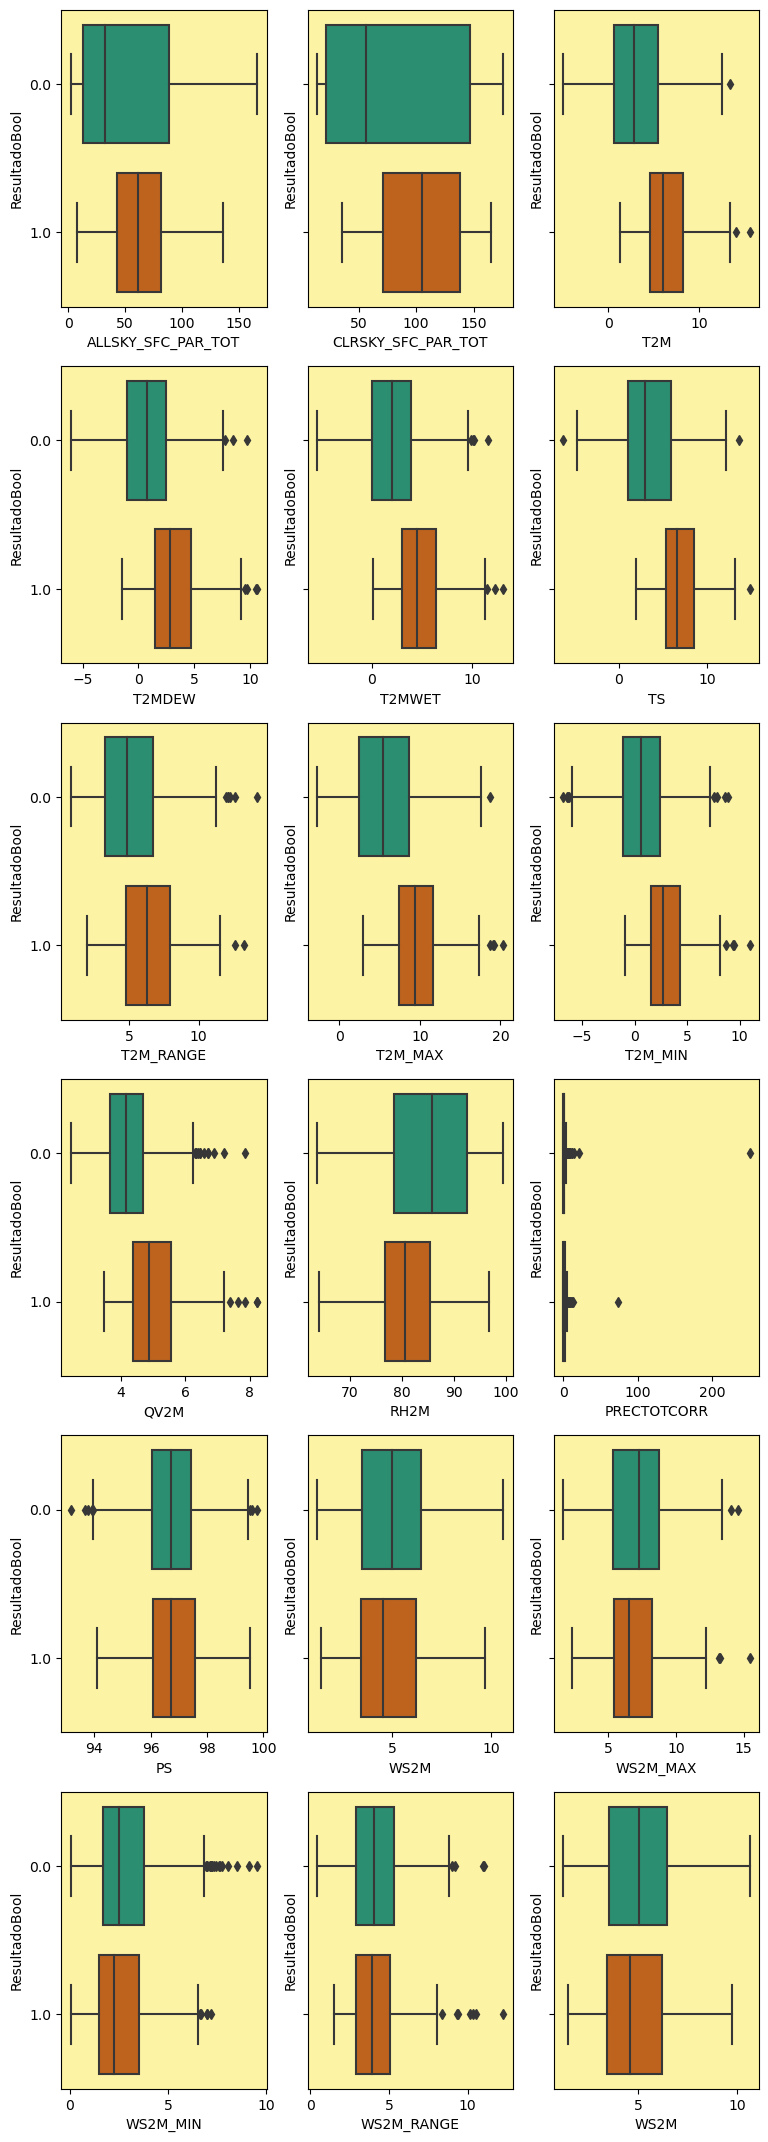

In [590]:
columnas= ["ALLSKY_SFC_PAR_TOT","CLRSKY_SFC_PAR_TOT","T2M","T2MDEW","T2MWET","TS","T2M_RANGE","T2M_MAX","T2M_MIN","QV2M","RH2M","PRECTOTCORR",
           "PS","WS2M","WS2M_MAX","WS2M_MIN","WS2M_RANGE","WS2M"]
index = 1
fig, ((ax1, ax2,ax3), (ax4, ax5,ax6),(ax7, ax8,ax9),(ax10, ax11,ax12),(ax13, ax14,ax15),(ax16, ax17,ax18)) = plt.subplots(6, 3, figsize=(9,27), sharey=True)
figuras = {"ax1":ax1,"ax2":ax2,"ax3":ax3,"ax4":ax4,"ax5":ax5,"ax6":ax6,"ax7":ax7,"ax8":ax8,"ax9":ax9,"ax10":ax10,"ax11":ax11,"ax12":ax12,"ax13":ax13,
           "ax14":ax14,"ax15":ax15,"ax16":ax16,"ax17":ax17,"ax18":ax18 }
for columna in columnas:
    sns.boxplot(ax=figuras["ax"+str(index)], data= df_unido, x =columna, y="ResultadoBool", orient="h")
    index +=1
plt.show()

**Estandarización de las variables numericas**

In [298]:
X= df_unido.loc[:, columnas].values
X = StandardScaler().fit_transform(X)
X = pd.DataFrame(X)
X.columns=columnas
X.head()


,ALLSKY_SFC_PAR_TOT,CLRSKY_SFC_PAR_TOT,T2M,T2MDEW,T2MWET,TS,T2M_RANGE,T2M_MAX,T2M_MIN,QV2M,RH2M,PRECTOTCORR,PS,WS2M,WS2M_MAX,WS2M_MIN,WS2M_RANGE,WS2M
0,0.155322,1.495588,2.230467,2.506018,2.405538,2.010930,0.347597,1.907482,2.623111,2.975140,-0.479744,-0.075699,-0.610930,0.089592,0.043325,-0.431855,0.471843,0.089592
1,1.578687,1.488234,1.590407,0.898169,1.308187,1.590035,0.643594,1.387878,1.575936,0.868182,-1.908911,-0.185311,-1.001122,1.526506,1.298493,0.648229,1.117061,1.526506
2,1.516703,1.494888,0.720729,0.325704,0.553961,0.930254,-0.130227,0.537405,0.931246,0.209082,-1.119931,-0.024478,-0.106537,0.201296,-0.019644,0.594818,-0.588559,0.201296
3,0.980934,1.466521,0.766653,0.527127,0.673731,0.844938,0.575938,0.803032,0.738907,0.403571,-0.862356,-0.008087,0.816599,0.348541,0.114689,0.660098,-0.470736,0.348541
4,1.361870,1.475451,1.535873,1.272745,1.447379,1.499031,0.973419,1.441469,1.387159,1.192330,-1.128683,-0.186336,0.930801,-0.220131,-0.338683,-0.639563,0.152039,-0.220131


In [299]:
pca = PCA(n_components=3)

principalComponents = pca.fit_transform(X)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC_1', 'PC_2',"PC_3"])
finalDf = pd.concat([principalDf, df_unido[['ResultadoBool']]], axis = 1)
finalDf.head()


,PC_1,PC_2,PC_3,ResultadoBool
0,6.035213,-0.569002,-2.387428,0.0
1,4.688446,2.787600,0.345918,0.0
2,2.390068,0.486782,1.093053,0.0
3,2.545925,0.347065,0.929087,0.0
4,4.406542,-1.036674,0.568240,0.0


<IPython.core.display.Javascript object>


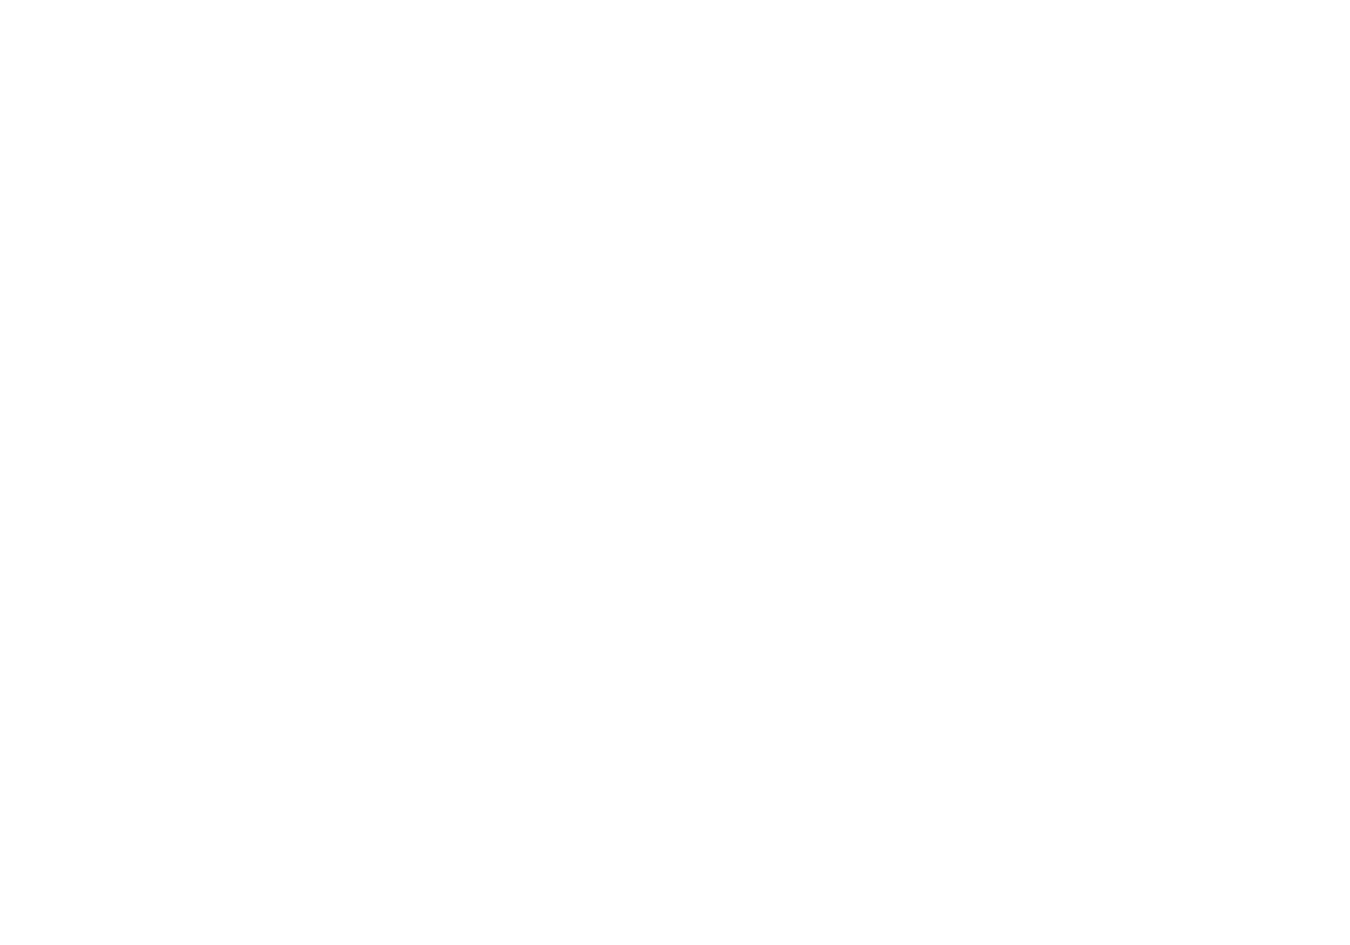

In [597]:
%matplotlib notebook
sns.set_style(rc = {'axes.facecolor': 'white'})
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 

ax.scatter3D(finalDf["PC_1"], finalDf["PC_2"],finalDf["PC_3"], c = finalDf["ResultadoBool"])
plt.title("Visualizacion Componentes Principales segun Resultado")
plt.show()

## Preparacion y entrenamiento de modelos de clasificación


### Regresión Logística

**División del dataset en datos de entrenamiento y de prueba**

In [476]:
y= df_unido["ResultadoBool"].astype("int64")

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.7, random_state= 1234,shuffle= True)

**Oversampling**

In [477]:
sm = SMOTE(k_neighbors=5, random_state=1234)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)
print('Antes del OverSampling, tamaño de X_train: {}'.format(X_train.shape))
print('Antes del OverSampling, tamaño de  y_train: {}'.format(y_train.shape))
print('Despues del OverSampling, tamaño de X_train_smote: {}'.format(X_train_smote.shape))
print('Despues del OverSampling, tamaño de y_train_smote: {}'.format(y_train_smote.shape))

Antes del OverSampling, tamaño de X_train: (510, 18)
Antes del OverSampling, tamaño de  y_train: (510,)
Despues del OverSampling, tamaño de X_train_smote: (748, 18)
Despues del OverSampling, tamaño de y_train_smote: (748,)


**Creación y entrenamiento de modelo de Regresión Logística**

In [599]:
y_train_smote= np.array(y_train_smote).reshape(-1,1)

In [602]:
modelo = LogisticRegression(C= 5,solver="liblinear",max_iter=10000, penalty="l1")
modelo.fit(X = X_train_smote, y = y_train_smote.ravel())

LogisticRegression(C=5, max_iter=10000, penalty='l1', solver='liblinear')

**Metricas de rendimiento del modelo de Regresión Logística**

In [615]:
print("Precision de prueba:", modelo.score(X_train, y_train))

Precision de prueba: 0.8647058823529412


In [617]:
prob_predict = modelo.predict_proba(X = X_train)
prob_predict = pd.DataFrame(predicciones, columns = modelo.classes_)
pd.DataFrame(predicciones).head()

,0,1
0,0.983956,0.016044
1,0.964325,0.035675
2,0.987282,0.012718
3,0.077287,0.922713
4,0.870274,0.129726


In [614]:
kfold = KFold(n_splits=10)
cv_results = cross_val_score(modelo, X_train, y_train, cv=kfold, scoring='accuracy')
msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
print(f"Regresion Logistica: Media de precision:{round(cv_results.mean(),2)}, desviacion estandar:{round(cv_results.std(),2)}")

Regresion Logistica: Media de precision:0.88, desviacion estandar:0.04


In [624]:
predicciones_RL_train = modelo.predict(X_train)
predicciones_RL_test = modelo.predict(X_test)
predicciones_RL_set = modelo.predict(X)
print(f"La precision de entrenamiento es: {round(accuracy_score(y_train, predicciones_RL_train),3)}")
print(f"La precision de prueba es: {round(accuracy_score(y_test, predicciones_RL_test),3)}")
print(f"La precision del set de datos es: {round(accuracy_score(y, predicciones_RL_set),3)}")


La precision de entrenamiento es: 0.865
La precision de prueba es: 0.895
La precision del set de datos es: 0.874


In [661]:
%matplotlib inline
matriz_RL_test = confusion_matrix(y_test, predicciones_RL_test)
print(matriz_RL_test)

[[152  18]
 [  5  45]]


### Máquina de Soporte Vectorial

**Creación y entrenamiento del modelo**

In [634]:
modelo = SVC(C = 10, kernel = 'rbf', gamma="scale",random_state=123)
modelo.fit(X_train_smote, y_train_smote.ravel())

SVC(C=10, random_state=123)

**Predicciones del set de prueba**

In [635]:
predicciones_SVM_test = modelo.predict(X_test)
predicciones_SVM_test

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1],
      dtype=int64)

In [636]:
kfold = KFold(n_splits=10)
cv_results = cross_val_score(modelo, X_train, y_train, cv=kfold, scoring='accuracy')
msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
print(f"Maquina de Soporte Vectorial: Media de precision:{round(cv_results.mean(),2)}, desviacion estandar:{round(cv_results.std(),2)}")

Maquina de Soporte Vectorial: Media de precision:0.87, desviacion estandar:0.04


In [643]:
predicciones_SVM_train = modelo.predict(X_train)
predicciones_SVM_test = modelo.predict(X_test)
predicciones_SVM_set = modelo.predict(X)
print(f"La precision de entrenamiento es: {round(accuracy_score(y_train, predicciones_SVM_train),3)}")
print(f"La precision de prueba es: {round(accuracy_score(y_test, predicciones_SVM_test),3)}")
print(f"La precision del set de datos es: {round(accuracy_score(y, predicciones_SVM_set),3)}")

La precision de entrenamiento es: 0.963
La precision de prueba es: 0.905
La precision del set de datos es: 0.945


In [659]:
matriz_SVM_test = confusion_matrix(y_test, predicciones_SVM_test)
print(matriz_SVM_test)

[[161   9]
 [ 12  38]]


In [640]:
print (classification_report(y_test, predicciones_SVM_test))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       170
           1       0.81      0.76      0.78        50

    accuracy                           0.90       220
   macro avg       0.87      0.85      0.86       220
weighted avg       0.90      0.90      0.90       220



**Comparación de modelos**

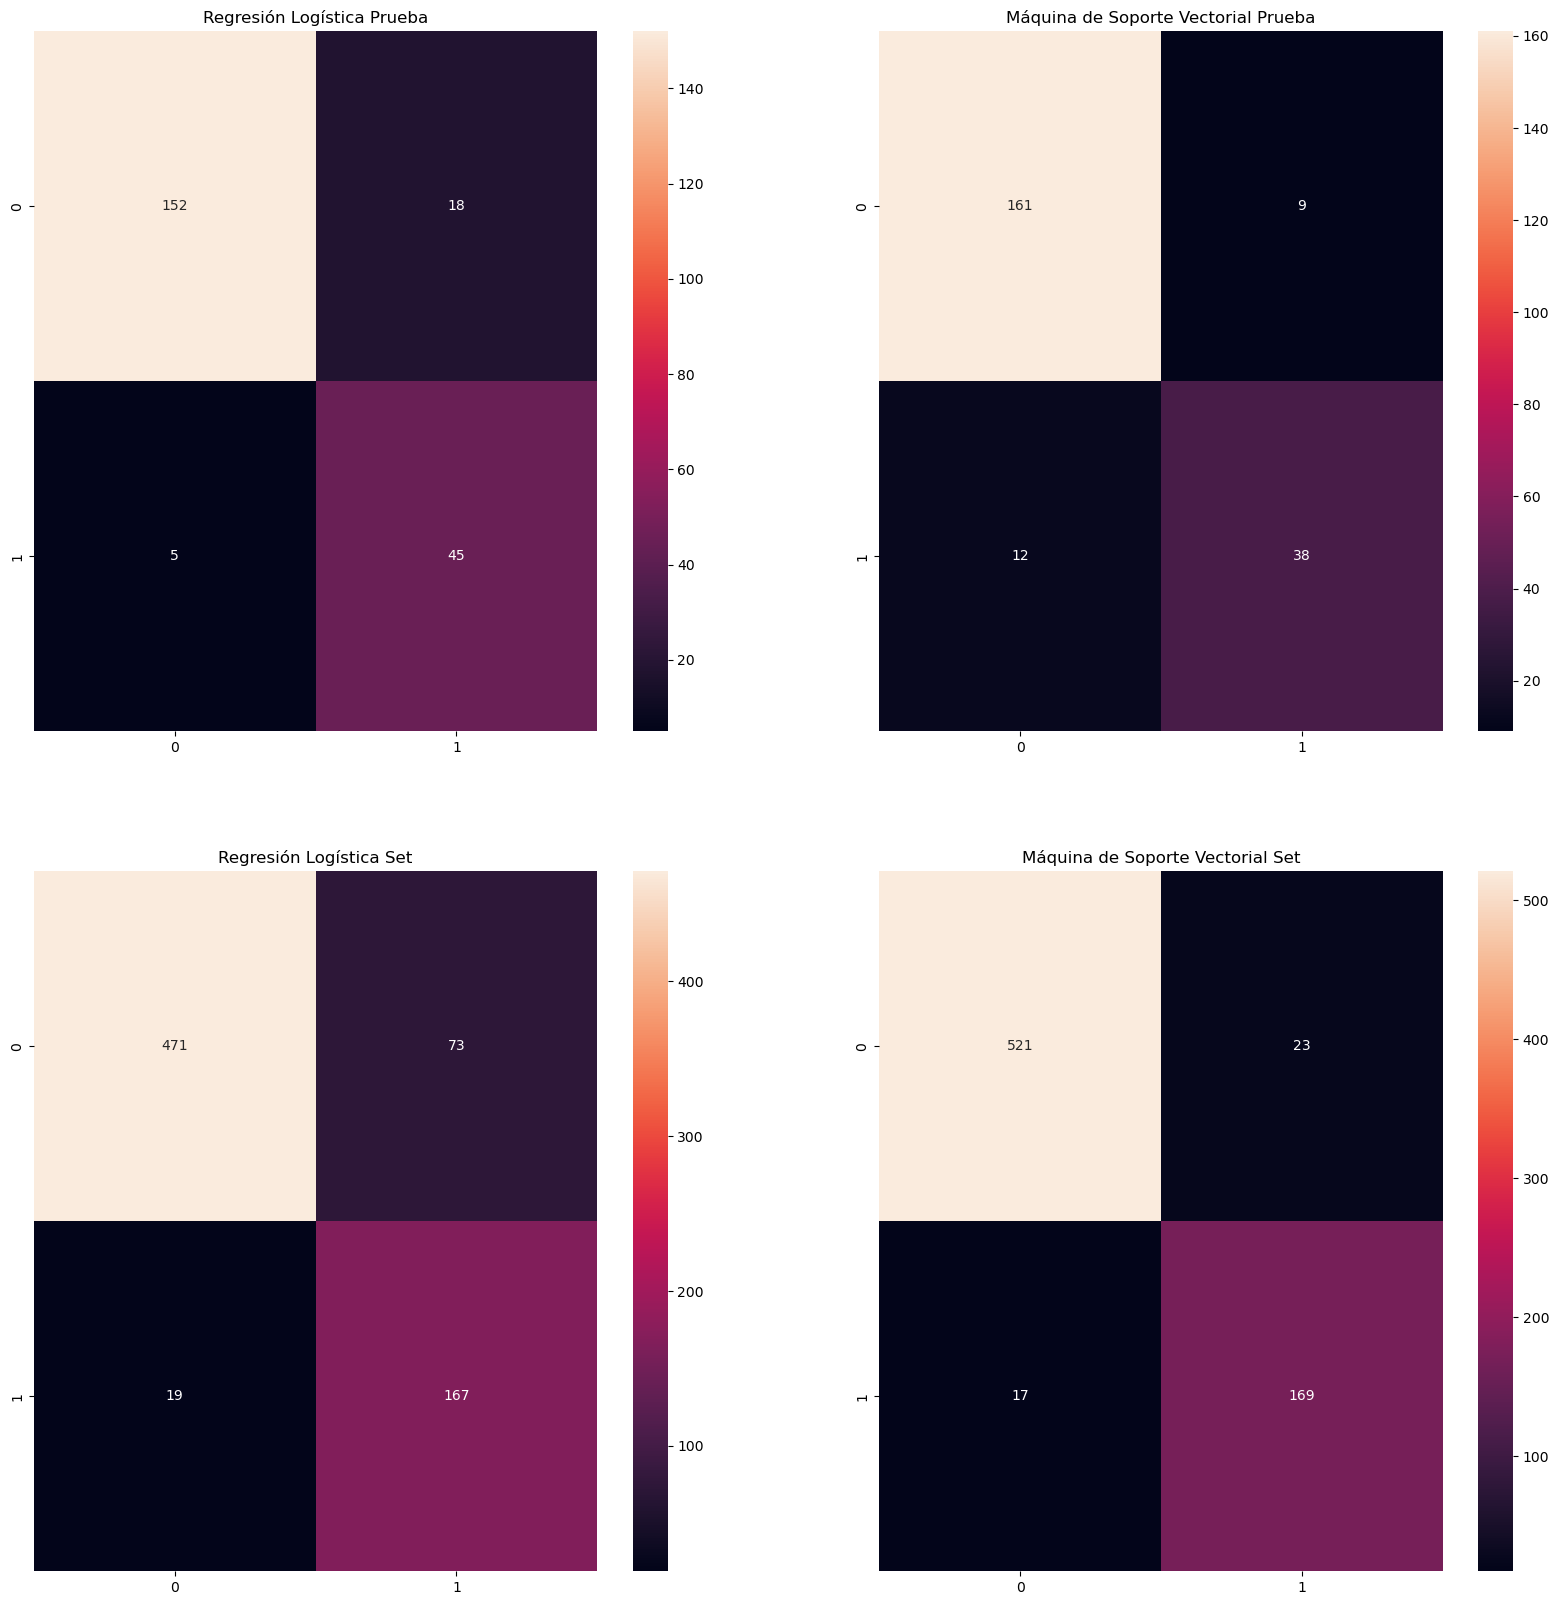

In [669]:
figura,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(20,20))
matriz_RL_set= confusion_matrix(y, predicciones_RL_set)
matriz_SVM_set= confusion_matrix(y, predicciones_SVM_set)

sns.heatmap(matriz_RL_test, annot=True,fmt='0', ax= ax1)
ax1.title.set_text('Regresión Logística Prueba')
sns.heatmap(matriz_SVM_test, annot=True,fmt='0', ax= ax2)
ax2.title.set_text('Máquina de Soporte Vectorial Prueba')
sns.heatmap(matriz_RL_set, annot=True,fmt='0', ax= ax3)
ax3.title.set_text('Regresión Logística Set')
sns.heatmap(matriz_SVM_set, annot=True,fmt='0', ax= ax4)
ax4.title.set_text('Máquina de Soporte Vectorial Set')
plt.show()

In [668]:
print("Reporte de Clasificación Regresión Logística")
print("\n")
print (classification_report(y, predicciones_RL_set))

Reporte de Clasificación Regresión Logística


              precision    recall  f1-score   support

           0       0.96      0.87      0.91       544
           1       0.70      0.90      0.78       186

    accuracy                           0.87       730
   macro avg       0.83      0.88      0.85       730
weighted avg       0.89      0.87      0.88       730



In [667]:
print("Reporte de Clasificación Máquina de Soporte Vectorial")
print("\n")
print (classification_report(y, predicciones_SVM_set))

Reporte de Clasificación Máquina de Soporte Vectorial


              precision    recall  f1-score   support

           0       0.97      0.96      0.96       544
           1       0.88      0.91      0.89       186

    accuracy                           0.95       730
   macro avg       0.92      0.93      0.93       730
weighted avg       0.95      0.95      0.95       730

